## Data Cleaning

In [16]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
from sklearn import preprocessing

### IMDB (courtesy of Nikhil)

In [17]:
conn = sqlite3.connect('Data/im.db')
imdb = pd.read_sql('''
Select *
    FROM movie_basics
    JOIN movie_ratings
        USING(movie_id)
''', conn)

imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [18]:
imdb.runtime_minutes.describe()

count    66236.000000
mean        94.654040
std        208.574111
min          3.000000
25%         81.000000
50%         91.000000
75%        104.000000
max      51420.000000
Name: runtime_minutes, dtype: float64

In [19]:
imdb.shape

(73856, 8)

In [20]:
imdb.numvotes.describe()

count    7.385600e+04
mean     3.523662e+03
std      3.029402e+04
min      5.000000e+00
25%      1.400000e+01
50%      4.900000e+01
75%      2.820000e+02
max      1.841066e+06
Name: numvotes, dtype: float64

In [21]:
len(imdb.query('numvotes > 750'))

11218

### The Movie Data Base

In [22]:
# read data in
tmdb = pd.read_csv('Data/tmdb.movies.csv', index_col=0)
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [23]:
tmdb.shape

(26517, 9)

In [24]:
tmdb.isna().any()

genre_ids            False
id                   False
original_language    False
original_title       False
popularity           False
release_date         False
title                False
vote_average         False
vote_count           False
dtype: bool

In [25]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


Here we can see that our release date isn't being treated as a datetime object. The genre IDs will also be more useful as lists rather than strings

In [26]:
# change release date to datetime
tmdb.release_date = pd.to_datetime(tmdb.release_date)
# turn genre ids into lists
tmdb.genre_ids = tmdb.genre_ids.str.strip('[]').str.split(',')
# remove whitespace from genre ids
tmdb.genre_ids = tmdb.genre_ids.apply(lambda x: [y.strip() for y in x])
# add release month column
tmdb['release_month'] = tmdb.release_date.dt.month
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
 9   release_month      26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.2+ MB


In [27]:
tmdb.describe()

,id,popularity,vote_average,vote_count,release_month
count,26517.000000,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837,6.405966
std,153661.615648,4.355229,1.852946,960.961095,3.573796
min,27.000000,0.600000,0.000000,1.000000,1.000000
25%,157851.000000,0.600000,5.000000,2.000000,3.000000
50%,309581.000000,1.374000,6.000000,5.000000,6.000000
75%,419542.000000,3.694000,7.000000,28.000000,10.000000
max,608444.000000,80.773000,10.000000,22186.000000,12.000000


Here we can see that many of the movies have very few votes under vote count which may influence the overall rating for that movie. We should make sure that there are a reasonable amount of votes before continuing with our analysis

In [28]:
# remove rows where there are fewer than 28 votes
tmdb_final = tmdb.query('vote_count >= 28').copy()
print(tmdb_final.shape)
tmdb_final.describe()

(6655, 10)


,id,popularity,vote_average,vote_count,release_month
count,6655.000000,6655.000000,6655.000000,6655.000000,6655.000000
mean,238238.404207,8.494026,6.214125,757.697521,6.749812
std,146714.620715,5.759755,0.982701,1804.396715,3.476064
min,27.000000,0.600000,1.600000,28.000000,1.000000
25%,86577.000000,5.258000,5.600000,52.000000,4.000000
50%,252680.000000,7.297000,6.200000,126.000000,7.000000
75%,359388.000000,10.015500,6.900000,511.000000,10.000000
max,569547.000000,80.773000,8.900000,22186.000000,12.000000


In [29]:
# create a new dataframe where the genre ids are separated
ids = []
genre_ids = []
vote_averages = []

popularity_by_genre = {'id': ids, 'genre_ids': genre_ids, 'vote_average': vote_averages}

for index, row in tmdb_final.iterrows():
    for genre in row[0]:
        ids.append(row[1])
        genre_ids.append(genre)
        vote_averages.append(row[7])

popularity_by_genre = pd.DataFrame(popularity_by_genre)
popularity_by_genre

,id,genre_ids,vote_average
0,12444,12,7.7
1,12444,14,7.7
2,12444,10751,7.7
3,10191,14,7.7
4,10191,12,7.7
...,...,...,...
15438,364379,35,6.5
15439,457775,99,5.3
15440,457775,27,5.3
15441,426258,53,5.8


In [30]:
popularity_by_genre[['genre_ids', 'vote_average']].groupby('genre_ids').describe()

vote_average                                                 
                 count      mean       std  min    25%  50%    75%  max
genre_ids                                                              
                   6.0  5.950000  0.915969  4.6  5.650  5.9  6.225  7.4
10402            211.0  6.782938  0.896869  4.5  6.100  6.8  7.400  8.9
10749            884.0  6.366516  0.803918  3.5  5.900  6.3  6.900  8.6
10751            565.0  6.360885  0.856582  1.6  5.800  6.4  6.900  8.5
10752            156.0  6.619231  0.921718  3.3  6.075  6.7  7.300  8.5
10770            201.0  6.200000  0.871206  3.5  5.900  6.3  6.700  7.9
12               720.0  6.228750  0.953534  2.9  5.700  6.3  6.900  8.4
14               530.0  6.303208  0.969755  3.2  5.700  6.3  7.000  8.5
16               543.0  6.744015  0.832701  2.1  6.200  6.7  7.400  8.6
18              3032.0  6.435158  0.826438  2.8  5.900  6.5  7.000  8.6
27              1005.0  5.354129  0.911893  2.0  4.800  5.3  6.000  7.9
28              1269.0  5.949961  1.002502  2.1  5.400  6.0  6.700  8.4
35              1932.0  6.166408  0.880366  1.6  5.600  6.2  6.800  8.4
36               243.0  6.852263  0.764897  3.9  6.500  6.9  7.350  8.5
37                67.0  6.144776  0.996856  4.0  5.500  6.2  6.800  8.0
53              1731.0  5.845292  0.892729  2.9  5.200  5.9  6.500  8.3
80               701.0  6.226106  0.813328  3.3  5.700  6.2  6.800  8.4
878              682.0  5.857038  1.163033  2.0  5.100  5.9  6.700  8.4
9648             510.0  6.043333  0.931708  3.3  5.500  6.1  6.600  8.5
99               455.0  7.214945  0.692691  4.4  6.800  7.3  7.700  8.6

## Data Understanding

In [31]:
# generate box and whisker plots to make case for normalization or remove outliers

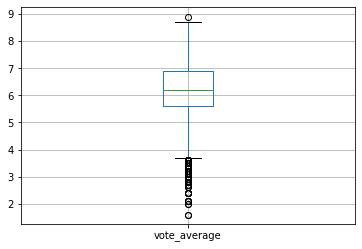

In [40]:
#popularity_by_genre['vote_average'].plot.hist()
popularity_by_genre.boxplot(column='vote_average',by='genre_id')

mean = popularity_by_genre.vote_average.mean()
median = popularity_by_genre.vote_average.median()
standDev = popularity_by_genre.vote_average.std()